In [29]:
#| hide
import sys
sys.path.append('../__pypackages__/3.9/lib/')
print(sys.path)

['/afs/crc.nd.edu/group/TAI/Users/painswor/nbdev-framework-example/nbs', '/opt/anaconda3/lib/python39.zip', '/opt/anaconda3/lib/python3.9', '/opt/anaconda3/lib/python3.9/lib-dynload', '', '/afs/crc.nd.edu/user/p/painswor/.local/lib/python3.9/site-packages', '/opt/anaconda3/lib/python3.9/site-packages', '/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions', '/afs/crc.nd.edu/user/p/painswor/.ipython', '../__pypackages__/3.9/lib/', '../__pypackages__/3.9/lib/', '../__pypackages__/3.9/lib/']


In [52]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
from datasets import Dataset,DatasetDict,load_dataset
import torch

# Evaluating Model

In [53]:
cleaned_data = "../data/cleaned-data"

Define kfold for evaluation

In [54]:
kfold = 1

Load Evaluation Dataset

In [55]:
val_dataset = pd.read_csv(f'{cleaned_data}/val/FAA-{kfold}.csv',header=0)

Import fine-tuned model

In [56]:
model_path = '../output/model'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [57]:
text = val_dataset.text

In [58]:
predictions = []
actual_predictions = []

for row in text:
    inputs = tokenizer(row, return_tensors="pt")
    
    with torch.no_grad():
        logits = model(**inputs).logits
    
    predictions.append(logits)
    actual_predictions.append(logits.argmax().item())

## Visualizations

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

### Prediction Heat Maps

Count correct predictions and add to heat map

In [60]:
correct = 0
heat_map = np.zeros((7,7), dtype=float)

for index, label in enumerate(val_dataset.label):
    if label == actual_predictions[index]:
        correct += 1
    
    heat_map[6 - actual_predictions[index]][label] = heat_map[ 6 - actual_predictions[index]][label] + 1

print("Correct based on my actual predictions: ", correct/len(actual_predictions))

Correct based on my actual predictions:  0.1409090909090909


Normalize heat map

In [61]:
for i, category in enumerate(heat_map):
    total = 0
    
    for val in category:
        total = total + val
        
    for j, val in enumerate(category):
        heat_map[i][j] = val / total

/tmp/ipykernel_871638/3763083728.py:8: RuntimeWarning: invalid value encountered in double_scalars
  heat_map[i][j] = val / total


Plot heat map

<AxesSubplot:>

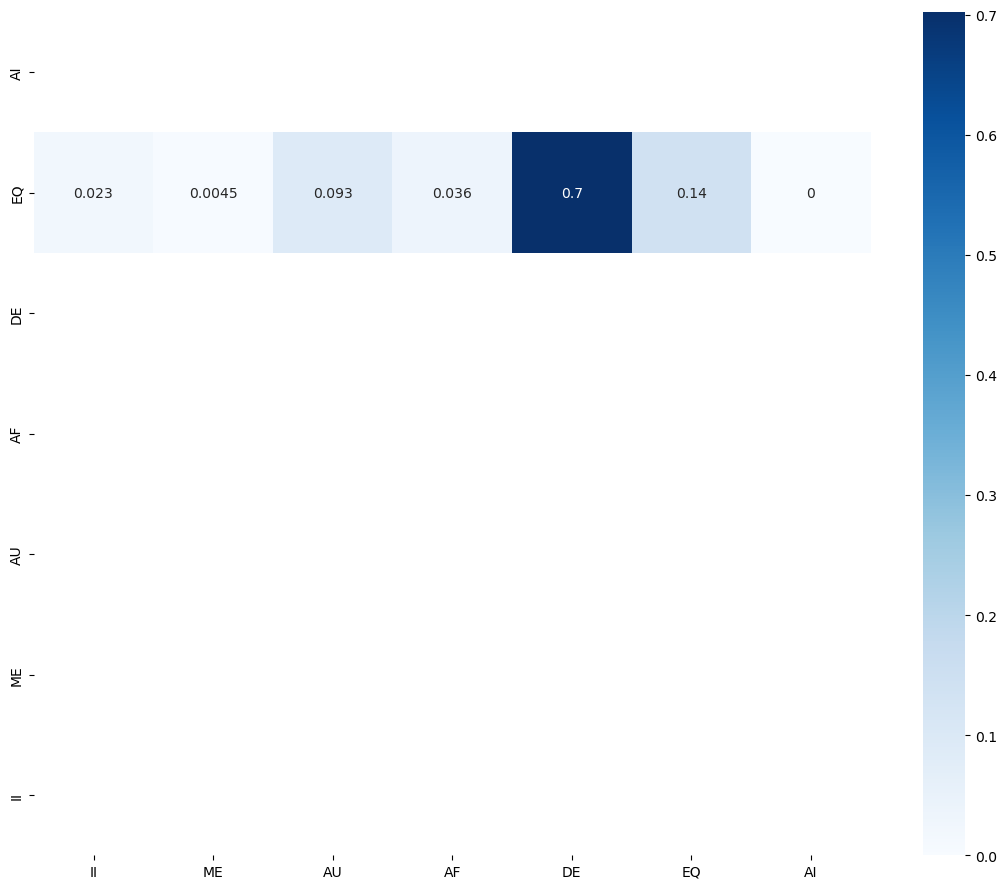

In [62]:
fig, ax = plt.subplots(figsize=(11,9))
fig.set_tight_layout(True)
# color map
labels = ['II','ME','AU','AF','DE','EQ','AI']
y_labels = ['AI','EQ','DE','AF','AU','ME','II']
sb.heatmap(heat_map,cmap="Blues",xticklabels=labels, yticklabels=y_labels, annot=True)

In [28]:
fig.savefig(f'../output/visualizations/heatmap-{kfold}.pdf')